In [ ]:
# ML project

**Exploratory Data Analysis**

**Initialize Spark**

In [1]:
# Spark init

!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz 
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/default-java"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
!pip install -q findspark
import findspark
findspark.init()

In [2]:
# Import pyspark session

from pyspark.sql.types import *
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [80]:

import os.path, json, io
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 20)
! pip install retrying
from retrying import retry # for exponential back down when calling TurboOverdrive API

import pyspark.sql.functions as func # resuse as func.coalace for example
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType,DecimalType
from pyspark.sql import SparkSession

import pandas as pd
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import shapely,Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
from ast import literal_eval as make_tuple # used to decode data from java

In [3]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load The Data**

In [4]:
# Read the data from raw files for 2015 and 2016 
df_raw_data_2016 = spark.read.csv('/content/drive/MyDrive/data/uber-raw-data-jantojune-16.csv', sep=',', header=True)
df_raw_data_2015 = spark.read.csv('/content/drive/MyDrive/data/uber-raw-data-jantojune-15.csv', sep=',', header=True)

In [5]:
# Display head to check the data read into dataframes

df_raw_data_2016.head(5)

[Row(id='id0190469', vendor_id='2', pickup_datetime='01/01/2016', dropoff_datetime='01/01/2016', passenger_count='5', pickup_longitude='-73.98174286', pickup_latitude='40.71915817', dropoff_longitude='-73.93882751', dropoff_latitude='40.82918167', store_and_fwd_flag='N', trip_duration='849'),
 Row(id='id1665586', vendor_id='1', pickup_datetime='01/01/2016', dropoff_datetime='01/01/2016', passenger_count='1', pickup_longitude='-73.98508453', pickup_latitude='40.74716568', dropoff_longitude='-73.95803833', dropoff_latitude='40.71749115', store_and_fwd_flag='N', trip_duration='1294'),
 Row(id='id1210365', vendor_id='2', pickup_datetime='01/01/2016', dropoff_datetime='01/01/2016', passenger_count='5', pickup_longitude='-73.96527863', pickup_latitude='40.80104065', dropoff_longitude='-73.94747925', dropoff_latitude='40.81517029', store_and_fwd_flag='N', trip_duration='408'),
 Row(id='id3888279', vendor_id='1', pickup_datetime='01/01/2016', dropoff_datetime='01/01/2016', passenger_count='1',

In [6]:
# Drop the columns that are not needed from the dataframe and store it in a new clean dataframe

cols =['id','vendor_id','dropoff_datetime','passenger_count','dropoff_longitude','dropoff_latitude','store_and_fwd_flag','trip_duration']

df_raw_data_2016_clean= df_raw_data_2016.drop(*cols)

In [7]:
# Display the clean dataframe to ensure the columns are dropped

df_raw_data_2016_clean.head(5)

[Row(pickup_datetime='01/01/2016', pickup_longitude='-73.98174286', pickup_latitude='40.71915817'),
 Row(pickup_datetime='01/01/2016', pickup_longitude='-73.98508453', pickup_latitude='40.74716568'),
 Row(pickup_datetime='01/01/2016', pickup_longitude='-73.96527863', pickup_latitude='40.80104065'),
 Row(pickup_datetime='01/01/2016', pickup_longitude='-73.98229218', pickup_latitude='40.75133133'),
 Row(pickup_datetime='01/01/2016', pickup_longitude='-73.97010803', pickup_latitude='40.75979996')]

In [8]:
# Drop the columns that are not needed from the dataframe and store it in a new clean dataframe

cols =['Dispatching_base_num','Affiliated_base_num','locationID']

df_raw_data_2015_clean= df_raw_data_2015.drop(*cols)

In [9]:
# Display the clean dataframe to ensure the columns are dropped

df_raw_data_2015_clean.head(5)

[Row(Pickup_date='05/17/2015', pickup_longitude='-73.93882751', pickup_latitude='40.82918167'),
 Row(Pickup_date='05/17/2015', pickup_longitude='-73.95803833', pickup_latitude='40.71749115'),
 Row(Pickup_date='05/17/2015', pickup_longitude='-73.94747925', pickup_latitude='40.81517029'),
 Row(Pickup_date='05/17/2015', pickup_longitude='-73.99134064', pickup_latitude='40.75033951'),
 Row(Pickup_date='05/17/2015', pickup_longitude='-73.98935699', pickup_latitude='40.74298859')]

In [10]:
# Combine the two dataframes into one

unionDF = df_raw_data_2016_clean.union(df_raw_data_2015_clean)
unionDF.show(truncate=False)

+---------------+----------------+---------------+
|pickup_datetime|pickup_longitude|pickup_latitude|
+---------------+----------------+---------------+
|01/01/2016     |-73.98174286    |40.71915817    |
|01/01/2016     |-73.98508453    |40.74716568    |
|01/01/2016     |-73.96527863    |40.80104065    |
|01/01/2016     |-73.98229218    |40.75133133    |
|01/01/2016     |-73.97010803    |40.75979996    |
|01/01/2016     |-73.97333527    |40.76407242    |
|01/01/2016     |-73.99310303    |40.75263214    |
|01/01/2016     |-73.98544312    |40.73571014    |
|01/01/2016     |-73.99373627    |40.74176025    |
|01/01/2016     |-73.97686005    |40.68337631    |
|01/01/2016     |-73.9697876     |40.75758362    |
|01/01/2016     |-73.99397278    |40.74086761    |
|01/01/2016     |-73.9595108     |40.76280975    |
|01/01/2016     |-73.99025726    |40.73703384    |
|01/01/2016     |-73.99013519    |40.74885178    |
|01/01/2016     |-74.00531769    |40.72866058    |
|01/01/2016     |-73.93579865  

In [11]:
# Display schema

unionDF.printSchema()

root
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)



In [12]:
# Change the dataype of the latitiude column
unionDF = unionDF.withColumn("pickup_latitude", unionDF['pickup_latitude'].\
           								cast(FloatType()))

In [13]:
# Chsnge the datatype of the longitude column
unionDF = unionDF.withColumn("pickup_longitude", unionDF['pickup_longitude'].\
           								cast(FloatType()))

In [14]:
# Convert the datetime column data type to date data type

from datetime import datetime

from pyspark.sql.functions import col, udf

from pyspark.sql.types import DateType

# Setting an user define function:

# This function converts the string cell into a date:

func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

unionDF = unionDF.withColumn('Date', func(col('pickup_datetime')))

unionDF.show()

unionDF.printSchema()

+---------------+----------------+---------------+----------+
|pickup_datetime|pickup_longitude|pickup_latitude|      Date|
+---------------+----------------+---------------+----------+
|     01/01/2016|       -73.98174|       40.71916|2016-01-01|
|     01/01/2016|      -73.985085|      40.747166|2016-01-01|
|     01/01/2016|       -73.96528|       40.80104|2016-01-01|
|     01/01/2016|       -73.98229|       40.75133|2016-01-01|
|     01/01/2016|       -73.97011|        40.7598|2016-01-01|
|     01/01/2016|      -73.973335|      40.764072|2016-01-01|
|     01/01/2016|        -73.9931|      40.752632|2016-01-01|
|     01/01/2016|       -73.98544|       40.73571|2016-01-01|
|     01/01/2016|       -73.99374|       40.74176|2016-01-01|
|     01/01/2016|       -73.97686|      40.683376|2016-01-01|
|     01/01/2016|       -73.96979|      40.757584|2016-01-01|
|     01/01/2016|       -73.99397|      40.740868|2016-01-01|
|     01/01/2016|       -73.95951|       40.76281|2016-01-01|
|     01

In [15]:
# Drop the datetime column of string type 
cols =['pickup_datetime']

unionDF= unionDF.drop(*cols)

In [16]:
# Display clean dataframe

unionDF.show()

+----------------+---------------+----------+
|pickup_longitude|pickup_latitude|      Date|
+----------------+---------------+----------+
|       -73.98174|       40.71916|2016-01-01|
|      -73.985085|      40.747166|2016-01-01|
|       -73.96528|       40.80104|2016-01-01|
|       -73.98229|       40.75133|2016-01-01|
|       -73.97011|        40.7598|2016-01-01|
|      -73.973335|      40.764072|2016-01-01|
|        -73.9931|      40.752632|2016-01-01|
|       -73.98544|       40.73571|2016-01-01|
|       -73.99374|       40.74176|2016-01-01|
|       -73.97686|      40.683376|2016-01-01|
|       -73.96979|      40.757584|2016-01-01|
|       -73.99397|      40.740868|2016-01-01|
|       -73.95951|       40.76281|2016-01-01|
|       -73.99026|      40.737034|2016-01-01|
|      -73.990135|       40.74885|2016-01-01|
|       -74.00532|       40.72866|2016-01-01|
|        -73.9358|       40.70731|2016-01-01|
|       -73.99496|       40.74512|2016-01-01|
|       -73.99046|      40.751007|

In [17]:
% pip install geopandas

     |████████████████████████████████| 1.0 MB 9.0 MB/s 
     |████████████████████████████████| 16.7 MB 47.3 MB/s 
     |████████████████████████████████| 6.3 MB 49.6 MB/s 


In [18]:
import geopandas as gpd
df = gpd.read_file('/content/drive/MyDrive/data/2010NeighborhoodTabulationAreas.geojson')

ntacode        195
shape_area     195
county_fips    195
ntaname        195
shape_leng     195
boro_name      195
boro_code      195
geometry       195
dtype: int64

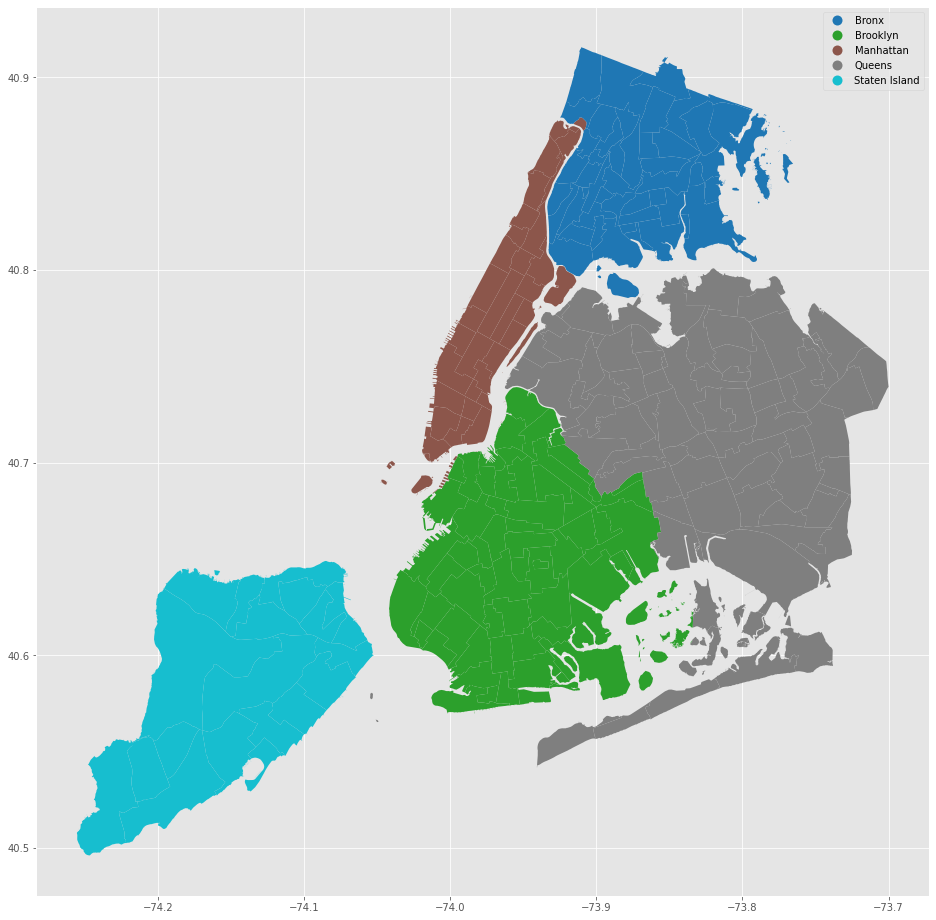

In [77]:

df.plot(column='boro_name', categorical=True, legend=True)
df.count()


In [20]:
# This is the value of the geopandas dataframe
df

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,QN51,52488277.4492,081,Murray Hill,33266.9048559,Queens,4,"MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ..."
1,QN27,19726845.734,081,East Elmhurst,19816.7117581,Queens,4,"MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ..."
2,QN41,27774853.5522,081,Fresh Meadows-Utopia,22106.4312724,Queens,4,"MULTIPOLYGON (((-73.77758 40.73019, -73.77849 ..."
3,QN08,77412747.8943,081,St. Albans,45401.3167856,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
4,BK69,20528197.0269,047,Clinton Hill,23971.4662361,Brooklyn,3,"MULTIPOLYGON (((-73.95337 40.68064, -73.95328 ..."
...,...,...,...,...,...,...,...,...
190,BX27,49692926.0514,005,Hunts Point,43702.2160145,Bronx,2,"MULTIPOLYGON (((-73.88439 40.82295, -73.88436 ..."
191,BX39,41898929.8816,005,Mott Haven-Port Morris,35604.9726086,Bronx,2,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
192,MN34,24494900.5685,061,East Harlem North,30603.7155941,Manhattan,1,"MULTIPOLYGON (((-73.92719 40.79735, -73.92735 ..."
193,BX14,18221640.2327,005,East Concourse-Concourse Village,27199.9115779,Bronx,2,"MULTIPOLYGON (((-73.90959 40.84276, -73.90962 ..."


In [64]:
# This step was done to convert the multipolyhgon field into polygon
exploded = df.explode(index_parts=True)
exploded


ntacode     shape_area county_fips                           ntaname  \
0   0    QN51  52488277.4492         081                       Murray Hill   
1   0    QN27   19726845.734         081                     East Elmhurst   
2   0    QN41  27774853.5522         081              Fresh Meadows-Utopia   
3   0    QN08  77412747.8943         081                        St. Albans   
4   0    BK69  20528197.0269         047                      Clinton Hill   
...       ...            ...         ...                               ...   
192 2    MN34  24494900.5685         061                 East Harlem North   
    3    MN34  24494900.5685         061                 East Harlem North   
    4    MN34  24494900.5685         061                 East Harlem North   
193 0    BX14  18221640.2327         005  East Concourse-Concourse Village   
194 0    BX34  17271763.8139         005    Melrose South-Mott Haven North   

          shape_leng  boro_name boro_code  \
0   0  33266.9048559     Queens         4   
1   0  19816.7117581     Queens         4   
2   0  22106.4312724     Queens         4   
3   0  45401.3167856     Queens         4   
4   0  23971.4662361   Brooklyn         3   
...              ...        ...       ...   
192 2  30603.7155941  Manhattan         1   
    3  30603.7155941  Manhattan         1   
    4  30603.7155941  Manhattan         1   
193 0  27199.9115779      Bronx         2   
194 0  19589.1955773      Bronx         2   

                                                geometry  
0   0  POLYGON ((-73.80379 40.77561, -73.80099 40.775...  
1   0  POLYGON ((-73.86110 40.76366, -73.85993 40.762...  
2   0  POLYGON ((-73.77758 40.73019, -73.77849 40.729...  
3   0  POLYGON ((-73.75205 40.70523, -73.75174 40.704...  
4   0  POLYGON ((-73.95337 40.68064, -73.95328 40.680...  
...                                                  ...  
192 2  POLYGON ((-73.92667 40.80018, -73.92670 40.800...  
    3  POLYGON ((-73.92689 40.80084, -73.92651 40.800...  
    4  POLYGON ((-73.93381 40.81651, -73.93383 40.815...  
193 0  POLYGON ((-73.90959 40.84276, -73.90962 40.842...  
194 0  POLYGON ((-73.90129 40.82048, -73.90160 40.819...  

[368 rows x 8 columns]

In [69]:
# This step was dont to convert a Polygon field to a point field

points = exploded.copy()
# change geometry 
points['geometry'] = points['geometry'].centroid
points.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


,,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,0,QN51,52488277.4492,081,Murray Hill,33266.9048559,Queens,4,POINT (-73.80955 40.76835)
1,0,QN27,19726845.734,081,East Elmhurst,19816.7117581,Queens,4,POINT (-73.86840 40.76335)
2,0,QN41,27774853.5522,081,Fresh Meadows-Utopia,22106.4312724,Queens,4,POINT (-73.78372 40.73489)
3,0,QN08,77412747.8943,081,St. Albans,45401.3167856,Queens,4,POINT (-73.76315 40.69120)
4,0,BK69,20528197.0269,047,Clinton Hill,23971.4662361,Brooklyn,3,POINT (-73.96236 40.68797)


In [78]:
#This stored proc was created to convert the Points 

def geopandas_df_to_spark_df_for_points(gdf):
  gdf['lon'] = gdf['geometry'].x
  gdf['lat'] = gdf['geometry'].y
  sdf = spark.createDataFrame(pd.DataFrame(gdf).drop(['geometry'],axis = 1))
  return sdf

In [81]:
#This is the geopandas data into a spark dataframe, with points
spark_geo_df = geopandas_df_to_spark_df_for_points(points)
spark_geo_df.show()
spark_geo_df.count()

+-------+-------------+-----------+--------------------+-------------+-------------+---------+------------------+------------------+
|ntacode|   shape_area|county_fips|             ntaname|   shape_leng|    boro_name|boro_code|               lon|               lat|
+-------+-------------+-----------+--------------------+-------------+-------------+---------+------------------+------------------+
|   QN51|52488277.4492|        081|         Murray Hill|33266.9048559|       Queens|        4|-73.80954590112775| 40.76835158791797|
|   QN27| 19726845.734|        081|       East Elmhurst|19816.7117581|       Queens|        4| -73.8683955982344|40.763352201165496|
|   QN41|27774853.5522|        081|Fresh Meadows-Utopia|22106.4312724|       Queens|        4|-73.78371636114146| 40.73489448639481|
|   QN08|77412747.8943|        081|          St. Albans|45401.3167856|       Queens|        4| -73.7631460750064| 40.69120183506941|
|   BK69|20528197.0269|        047|        Clinton Hill|23971.4662361

368

In [85]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
unionDF = unionDF.withColumn("day", dayofmonth("Date"))
unionDF.show()

+----------------+---------------+----------+---+
|pickup_longitude|pickup_latitude|      Date|day|
+----------------+---------------+----------+---+
|       -73.98174|       40.71916|2016-01-01|  1|
|      -73.985085|      40.747166|2016-01-01|  1|
|       -73.96528|       40.80104|2016-01-01|  1|
|       -73.98229|       40.75133|2016-01-01|  1|
|       -73.97011|        40.7598|2016-01-01|  1|
|      -73.973335|      40.764072|2016-01-01|  1|
|        -73.9931|      40.752632|2016-01-01|  1|
|       -73.98544|       40.73571|2016-01-01|  1|
|       -73.99374|       40.74176|2016-01-01|  1|
|       -73.97686|      40.683376|2016-01-01|  1|
|       -73.96979|      40.757584|2016-01-01|  1|
|       -73.99397|      40.740868|2016-01-01|  1|
|       -73.95951|       40.76281|2016-01-01|  1|
|       -73.99026|      40.737034|2016-01-01|  1|
|      -73.990135|       40.74885|2016-01-01|  1|
|       -74.00532|       40.72866|2016-01-01|  1|
|        -73.9358|       40.70731|2016-01-01|  1|


In [46]:
unionDF = unionDF.withColumn("month", month("Date"))
unionDF.show(2)

+----------------+---------------+----------+---+-----+
|pickup_longitude|pickup_latitude|      Date|day|month|
+----------------+---------------+----------+---+-----+
|       -73.98174|       40.71916|2016-01-01|  1|    1|
|      -73.985085|      40.747166|2016-01-01|  1|    1|
+----------------+---------------+----------+---+-----+
only showing top 2 rows



In [19]:
unionDF = unionDF.withColumn("Year", year("Date"))
unionDF.show(2)

+----------------+---------------+----------+---+-----+----+
|pickup_longitude|pickup_latitude|      Date|day|month|Year|
+----------------+---------------+----------+---+-----+----+
|       -73.98174|       40.71916|2016-01-01|  1|    1|2016|
|      -73.985085|      40.747166|2016-01-01|  1|    1|2016|
+----------------+---------------+----------+---+-----+----+
only showing top 2 rows



In [20]:
unionDF = unionDF.withColumn("dayofweek", date_format("date", 'E'))
unionDF.show(2)

+----------------+---------------+----------+---+-----+----+---------+
|pickup_longitude|pickup_latitude|      Date|day|month|Year|dayofweek|
+----------------+---------------+----------+---+-----+----+---------+
|       -73.98174|       40.71916|2016-01-01|  1|    1|2016|      Fri|
|      -73.985085|      40.747166|2016-01-01|  1|    1|2016|      Fri|
+----------------+---------------+----------+---+-----+----+---------+
only showing top 2 rows



**Number of Trips in year**

In [21]:
n_trips_of_year = unionDF.groupby('Year').count().orderBy('year')
n_trips_of_year.show(2)

+----+-------+
|Year|  count|
+----+-------+
|2015|1048575|
|2016|1048575|
+----+-------+



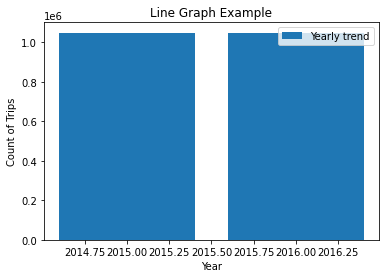

In [22]:
import matplotlib.pyplot as plt
import pandas


x= n_trips_of_year.toPandas()['Year'].values.tolist()

y= n_trips_of_year.toPandas()["count"].values.tolist()

plt.bar(x , y  , label="Yearly trend")
plt.plot()

plt.xlabel("Year")
plt.ylabel("Count of Trips")
plt.title("Line Graph Example")
plt.legend()
plt.show()

**Number of Trips in months**

In [23]:
n_trips_month = unionDF.groupby(unionDF["month"]).count()
n_trips_month.show(2)

+-----+------+
|month| count|
+-----+------+
|    1|363483|
|    6|361203|
+-----+------+
only showing top 2 rows



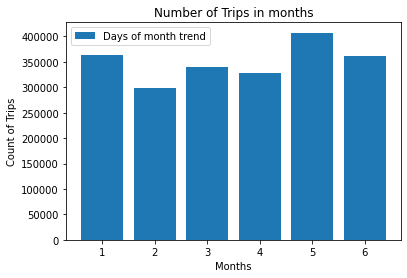

In [24]:
import matplotlib.pyplot as plt
import pandas


x= n_trips_month.toPandas()['month'].values.tolist()

y= n_trips_month.toPandas()["count"].values.tolist()

plt.bar(x , y  , label="Days of month trend")
plt.plot()

plt.xlabel("Months")
plt.ylabel("Count of Trips")
plt.title("Number of Trips in months")
plt.legend()
plt.show()

**Number of Trips in days of months**

In [25]:
n_trips_of_day = unionDF.groupby('day').count()
n_trips_of_day.show(2)

+---+-----+
|day|count|
+---+-----+
| 31|52778|
| 28|80293|
+---+-----+
only showing top 2 rows



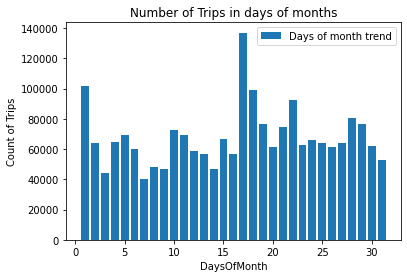

In [26]:
import matplotlib.pyplot as plt
import pandas


x= n_trips_of_day.toPandas()['day'].values.tolist()

y= n_trips_of_day.toPandas()["count"].values.tolist()

plt.bar(x , y  , label="Days of month trend")
plt.plot()

plt.xlabel("DaysOfMonth")
plt.ylabel("Count of Trips")
plt.title("Number of Trips in days of months")
plt.legend()
plt.show()

**Number of Trips in days of week**

In [27]:
n_trips_dayofweek = unionDF.groupby(unionDF["dayofweek"]).count()
n_trips_dayofweek.show(2)

+---------+------+
|dayofweek| count|
+---------+------+
|      Sun|305080|
|      Mon|288227|
+---------+------+
only showing top 2 rows



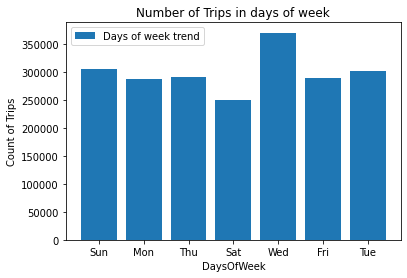

In [ ]:
import matplotlib.pyplot as plt
import pandas


x= n_trips_dayofweek.toPandas()['dayofweek'].values.tolist()

y= n_trips_dayofweek.toPandas()["count"].values.tolist()

plt.bar(x , y  , label="Days of week trend")
plt.plot()

plt.xlabel("DaysOfWeek")
plt.ylabel("Count of Trips")
plt.title("Number of Trips in days of week")
plt.legend()
plt.show()